### Parallel algorithm

In [50]:
%%writefile test.py

from mpi4py import MPI

import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt

def drawBoundingBoxes(img, l):
    img3 = img.copy()

    for pt in l:
        
        x_min, y_min, width, height = pt
        
        cv2.rectangle(img3, (int(x_min*img3.shape[0]),
                             int(y_min*img3.shape[1])),
                      (int((x_min+width)*img3.shape[0]),
                       int((y_min+height)*img3.shape[1])), (255,0,0), 15)
    return img3

def getBbox(a):
    x_max, y_max = np.max(a,axis=0)
    x_min, y_min = np.min(a,axis=0)
    return x_min, y_min, x_max, y_max

def predict_image(img_t: np.ndarray, img1: np.ndarray) -> list:
    
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
    
    n = int(size ** 0.5)
    height = img_t.shape[0]
    width = img_t.shape[1]
    
    offset = [0, 0]
    
    if n * n == size:
        # size is full square than we cut image by n x n grid
        i = rank // n # row number
        j = rank % n # col number
        #print('i',i,'j',j)
        
        offset[0] = width * j // n
        offset[1] = height * i // n
        
        img2 = img_t[offset[1]:height * (i+1) // n, offset[0]:width * (j+1) // n].copy()
        
        #print(width, height)
        #print(offset[1],height * (i+1) // n,offset[0],width * (j+1) // n)
        #print(f'img2_{rank}.jpg', cv2.imwrite(f'img2_{rank}.jpg',img2))
        
    else:
        # size is not full square, than we cut by n x 1 grid
        
        i = rank # row number
        
        offset[0] = 0
        offset[1] = height * i // size
        
        img2 = img_t[offset[1]:height * (i+1) // size, :].copy()
        #print(f'img2_{rank}.jpg', cv2.imwrite(f'img2_{rank}.jpg',img2))
    
    if(len(img2.shape) == 3):
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        
    if(len(img1.shape) == 3):
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        
    MIN_MATCH_COUNT = 10
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    list_of_bboxes = []
    param = 0.9
    while True:

        kp2, des2 = sift.detectAndCompute(img2, None)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        good_matches = []
        for m,n in matches:
            if m.distance < param*n.distance:
                good_matches.append(m)

        if len(good_matches) > MIN_MATCH_COUNT:

            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2)
            
            if M.ndim >= 2:
                deter = np.linalg.det(M)
            elif deter > 2 or deter < 0.5:

                dst_pts = dst_pts.reshape(-1,2)

                kmeans = KMeans(n_clusters=3)
                clusters = kmeans.fit(dst_pts)

                counter = Counter(kmeans.labels_)
                largest_cluster_idx = np.argmax(counter.values())

                good_matches = np.asarray(good_matches)[clusters.labels_ == largest_cluster_idx]

                src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

                if len(src_pts)<4 or len(dst_pts)<4:
                    if param <= 0.7:
                        break
                    else:
                        param -= 0.05
                        continue
                
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2)

                deter = 0
                if M is not None and M.ndim >= 2:
                    deter = np.linalg.det(M)
            
            if deter < 0.5 or deter > 4:
                if param <= 0.7:
                    break
                else:
                    param -= 0.05
                    continue
            else:
                h,w = img1.shape[0], img1.shape[1]
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                dst = cv2.perspectiveTransform(pts, M)
                
                x_min, y_min, x_max, y_max = getBbox(dst.reshape(-1,2))
                width = (x_max - x_min) / img_t.shape[0]
                height = (y_max - y_min) / img_t.shape[1]
                
                x_min = (x_min+offset[0]) / img_t.shape[0]
                y_min = (y_min+offset[1]) / img_t.shape[1]
                
                #if ((x_min>=0) and (width<=1) and (height<=1) and (y_min>=0)):
                #    list_of_bboxes.append((x_min,y_min,width,height))
                list_of_bboxes.append((x_min,y_min,width,height))
                
                cv2.fillPoly(img2, [np.int32(dst)], 255)
        else:
            if param <= 0.7:
                break
            else:
                param -= 0.05
                continue
    
    #print('rank',rank,'finished!')
    list_of_bboxes = comm.reduce(np.asarray(list_of_bboxes), op=np.append, root=0)
    
    if rank == 0:
        list_of_bboxes = np.asarray(list_of_bboxes).reshape(-1,4)
        
        #print('gather finished!')
        
        #print('list_of_bboxes',list_of_bboxes)
        #print('list_of_bboxes',list_of_bboxes.shape)
        
        
        print(cv2.imwrite('result_parallel.jpg',drawBoundingBoxes(img_t, list_of_bboxes)))
        #print('img_written!')
    
    #return
    #return list_of_bboxes

img1 = cv2.imread('template_0_0.jpg')   # queryImage
img2 = cv2.imread('train_0.jpg') # trainImage

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    start = MPI.Wtime()
    
predict_image(img2,img1)

if rank == 0:
    end = MPI.Wtime()
    print('Execution time:', end - start)

Overwriting test.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python3 test.py

In [ ]:
!mpirun --allow-run-as-root -n 2 python3 test.py

In [58]:
!mpirun --allow-run-as-root -n 3 python3 test.py

True
Execution time: 1.4957342


In [57]:
!mpirun --allow-run-as-root -n 4 python3 test.py

True
Execution time: 1.3271142


In [ ]:
data_time = np.asarray([
4.328174173999969,
1.3271142,
])


data_time = data_time[0] / data_time

plt.plot([1,2,4,5,8,10], data_time)
plt.xlabel("n (number of processes)",fontsize=16)
plt.ylabel("time [1 process] / time [n processes]",fontsize=16)
plt.show()

### Consequent algorithm

In [3]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt

def getBbox(a):
    x_max, y_max = np.max(a,axis=0)
    x_min, y_min = np.min(a,axis=0)
    return x_min, y_min, x_max, y_max

def predict_image(img_t: np.ndarray, query: np.ndarray) -> list:
    img2 = img_t.copy()
    img1 = query.copy()
    if(len(img2.shape) == 3):
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        
    if(len(img1.shape) == 3):
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        
    MIN_MATCH_COUNT = 10

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1, None)
    
    list_of_bboxes = []
    
    param = 0.9
    
    while True:

        kp2, des2 = sift.detectAndCompute(img2, None)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        #matches = sorted(matches, key = lambda x:x[0].distance/x[1].distance)

        good_matches = []
        for m,n in matches:
            if m.distance < param*n.distance:
                good_matches.append(m)

        if len(good_matches) > MIN_MATCH_COUNT:

            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2)
            
            if M.ndim >= 2:
                deter = np.linalg.det(M)
            elif deter > 2 or deter < 0.5:

                dst_pts = dst_pts.reshape(-1,2)

                kmeans = KMeans(n_clusters=3)
                clusters = kmeans.fit(dst_pts)

                counter = Counter(kmeans.labels_)
                largest_cluster_idx = np.argmax(counter.values())

                good_matches = np.asarray(good_matches)[clusters.labels_ == largest_cluster_idx]

                src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

                if len(src_pts)<4 or len(dst_pts)<4:
                    if param <= 0.7:
                        break
                    else:
                        param -= 0.05
                        continue
                
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2)

                deter = 0
                if M is not None and M.ndim >= 2:
                    deter = np.linalg.det(M)
            
            if deter < 0.5 or deter > 4:
                if param <= 0.7:
                    break
                else:
                    param -= 0.05
                    continue
            else:
                h,w = img1.shape[0], img1.shape[1]
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                dst = cv2.perspectiveTransform(pts, M)
                
                x_min, y_min, x_max, y_max = getBbox(dst.reshape(-1,2))
                width = (x_max - x_min) / img2.shape[0]
                height = (y_max - y_min) / img2.shape[1]
                
                x_min = x_min / img2.shape[0]
                y_min = y_min / img2.shape[1]
                
                if ((x_min>=0) and (width<=1) and (height<=1) and (y_min>=0)):
                    list_of_bboxes.append((x_min,y_min,width,height))
                
                cv2.fillPoly(img2, [np.int32(dst)], 255)
        else:
            if param <= 0.7:
                break
            else:
                param -= 0.05
                continue
    
    return list_of_bboxes

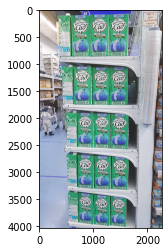

In [14]:
plt.imshow(img2)
plt.show()

In [4]:
img1 = cv2.imread('template_0_0.jpg')   # queryImage
img2 = cv2.imread('train_0.jpg') # trainImage
l = predict_image(img2,img1)

In [6]:
cv2.imwrite('train_0_detected.jpg',img3)

True

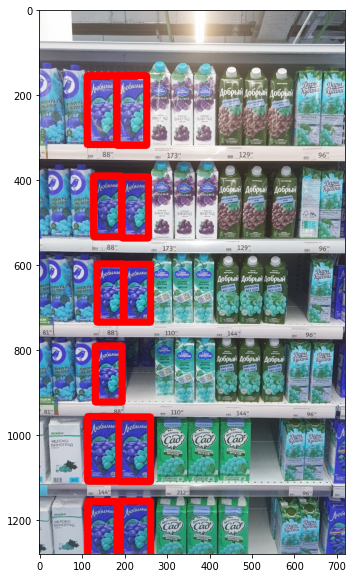

In [5]:
img3 = img2.copy()

for x_min, y_min, width, height in l:
    cv2.rectangle(img3, (int(x_min*img3.shape[0]),
                         int(y_min*img3.shape[1])),
                  (int((x_min+width)*img3.shape[0]),
                   int((y_min+height)*img3.shape[1])), (255,0,0), 15)
plt.figure(figsize=(10,10))
plt.imshow(img3)
plt.show()